In [ ]:
%%capture

# Step 1: Clone PySyft Library
! git clone --single-branch --branch 'syft_0.3.0' https://github.com/OpenMined/PySyft.git

# NOTICE: Part 2 runs installation calls specific to Colab. 
# Don't run this code if you're running PySyft locally. Just
# pull down 

# Step 2: Setup Colab Environment
! cd PySyft && ./scripts/colab.sh

import sys
sys.path.append("/content/PySyft/src") # prevents needing restart

In [4]:
# Step 3: Importing Syft
import syft as sy
sy.VERBOSE = False

# Part -1 : Join the Duet Server the Data Owner connected to

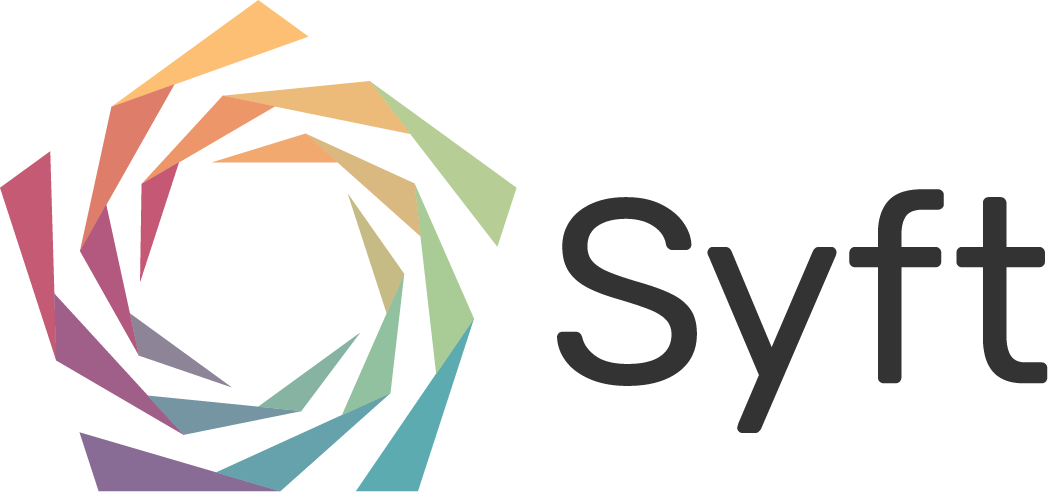

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ >             Use at your own risk.

♫♫♫ > 
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000/
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... DONE!

♫♫♫ > Duet Client ID: 3a522a7e7bfc0458f820d10e8477cb52

♫♫♫ > STEP 1: Send the Duet Client ID to your duet partner!

♫♫♫ > ...waiting for partner to connect...
♫♫♫ > ...using a running event loop...

♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet('713e79a7f26ad54b79f21785c1995d5a', network_url="http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000/")

# Part -2 : Search for Available Data


In [3]:
# The data scientist can check the list of searchable data in Data Owner's duet store
duet.store.pandas

ID           Tags  \
0  <UID: 50512b63e76b4fbfa29faef1155b8ea4>    [iris-data]   
1  <UID: 6dfcb15b2b59438a9a2b3bd0bbd84707>  [iris-target]   

                                         Description  
0  This is a dataset for flower classification of...  
1  Labels for flowers: Iris-setosa, Iris-versicol...

In [4]:
# Data Scientist wants to get the iris dataset. (S)He needs a pointer to the data and a pointer to the target for prediction.

data_ptr = duet.store[0]
target_ptr = duet.store[1]

# data_ptr.requires_grad = True
# target_ptr.requires_grad = True

# data_ptr is a reference to the iris dataset remotely available on data owner's server
# target_ptr is a reference to the iris dataset LABELS remotely available on data owner's server
print(data_ptr)
print(target_ptr)

# Part -3 : Perform Logistic Regression on iris dataset
Now the data scientist can perform machine learning on the data that is in the Data Owner's duet server, without the owner having to share his/her data.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to explicitly shared by the Data Owner. Let's try to find them in the data description.

In [5]:
print(duet.store.pandas['Description'][0])

print(duet.store.pandas['Description'][1])

This is a dataset for flower classification of 150 samples. 4 Features are sepal length (cm), sepal width (cm),petal length (cm), petal width (cm)
Labels for flowers: Iris-setosa, Iris-versicolour, Iris-virginica


### Train model

In [1]:
import torch

In [2]:
in_dim = 4
out_dim = 3
n_samples = 150

In [5]:
class SyNet(sy.Module):
    
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)
        
    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output
        
local_model = SyNet(torch)

> Creating local model


In [9]:
remote_model = local_model.send(duet)

> Sending local model
> Creating remote model
  Sending local layer: layer1
  Sending local layer: layer2
  Sending local layer: out

> Finished sending local model <




Let's create an alias for our partner’s torch called remote_torch so we can refer to the local torch as torch and any operation we want to do remotely as remote_torch. Remember, the return values from remote_torch are Pointers, not the real objects. They mostly act the same when using them with other Pointers but you can't mix them with local torch objects.

In [10]:
remote_torch = duet.torch

In [11]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)

In [12]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):
    
    losses = []
    
    for i in range(iterations):
        
        optim.zero_grad()
        
        output = model(data_ptr)
        
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())
        
        loss_item = loss.item()
        
        loss_value = loss_item.get(
                name="loss",
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=5
            )
        
        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)
        
        losses.append(loss_value)
        
        loss.backward()
        
        optim.step()
        
    return losses

In [13]:
iteration = 100
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 1.1313481330871582
Epoch 10 loss 0.6667858958244324
Epoch 20 loss 0.28654858469963074
Epoch 30 loss 0.11573798209428787
Epoch 40 loss 0.0686415433883667
Epoch 50 loss 0.05726451054215431
Epoch 60 loss 0.05214538052678108
Epoch 70 loss 0.04956570267677307
Epoch 80 loss 0.048328448086977005
Epoch 90 loss 0.047381315380334854


In [14]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

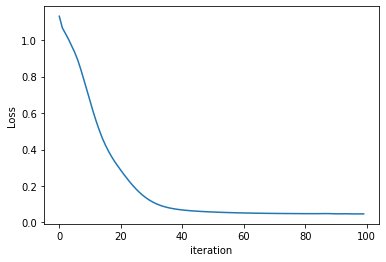

In [15]:
plt.plot(range(iteration), losses)
plt.ylabel('Loss')
plt.xlabel('iteration')

### Download model

In [16]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            name="model_download",
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else: 
        local_model = model
        
    return local_model

local_model = get_local_model(remote_model)

> Downloading remote model
> Creating local model

> Finished downloading remote model <




### Test on local data

In [25]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [18]:
iris_test = pd.read_csv('./data/iris-test.csv')
iris_test.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.8               4.0                1.2               0.2   
1                5.7               4.4                1.5               0.4   
2                6.0               2.7                5.1               1.6   
3                6.0               2.9                4.5               1.5   
4                5.8               2.7                5.1               1.9   

   species  
0        0  
1        0  
2        1  
3        1  
4        2

In [19]:
X_test = iris_test.loc[:, iris_test.columns != 'species']
y_test = iris_test['species']

In [20]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [23]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2


In [27]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc*100)

Overall test accuracy 93.33333333333333
